# Cables Characterization
FARE ATTENZIONE AI CAVI E ALLE LORO POSIZIONI. SONO DETERMINANTI PER LA PRESA DATI

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
from scipy.signal import find_peaks
from scipy.optimize import curve_fit


sys.path.insert(1, '..\\..\\Instruments\\network\\RS_Signal_Generator')
sys.path.insert(2, '..\\..\\Instruments\\Acquisition_Card')
sys.path.insert(4, '..\\..\\HDF5')
sys.path.insert(5, '..\\')
from HDF5 import load_hdf5_to_dict, save_dict_to_hdf5
import Tools as T

flag_acquisition 	= False
flag_load_data 		= True


if flag_acquisition:
	import RS_SMA100B
	from Card_Class import PXIe5170R
	

In [2]:
if flag_acquisition:
	SG_ip           = '192.168.40.15'                                   # Set IP address of the device
	Card_Name       = 'PXI1Slot3'

	sGen            = RS_SMA100B.SMA100B(ip = SG_ip)
	pxie            = PXIe5170R(resource_name = Card_Name)

	sGen.reset()
	sGen.clear()

In [3]:
if flag_acquisition:
	sample_rate     = 250e6                                             # Maximum Value: 250.0e6
	k = 4                                                               # coefficiente per prendere k*1000 punti 
																		# con la scheda, dunque devo aumentare la pulse width e period
	pulse_period    = k * 1e-6                                          # 4e-6 con 250e6 dà 1000 punti
	num_pts         = int(sample_rate * pulse_period)                   # min 5ns                             
	pulse_delay     = 0
	percent         = 5
	pulse_width     = pulse_period * (1 - percent/100)                  # min 20ns


	# parameters for the Signal Generator
	sGen.pul_gen_params(delay = pulse_delay, 
						width = pulse_width, 
						period = pulse_period)   # da capire quale pulse width
	sGen.pul_gen_mode('SING')
	sGen.pul_trig_mode('SING')


	# parameters for the Acquisition Card
	pxie.voltage_range      = 0.5
	pxie.coupling           = 'AC' # or DC????
	pxie.num_pts            = num_pts
	pxie.num_records        = 1
	pxie.ref_position       = 0
	pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6

In [4]:
if flag_acquisition:
	# -------------------------- #

	cable_name      = 'C_D'
	pulse_freq      = 1e7
	amp_min		    = -20                                               # Set the amplitude of the signal in dBm
	amp_max         = 1
	amps            = np.arange(amp_min, amp_max, 1)

	# -------------------------- #

	trig_CH     = 3
	cable_CH    = 0

	sGen.RF_freq(pulse_freq) 
	pxie.open(trigger_channel = str(trig_CH))

	data_dict   = {cable_name: {'freq_(Hz)': pulse_freq, 'powers': {}}}
	counter     = 1

	digits_p = "{:0"+str(len(str(len(amps))))+"d}"


	for i, amp in enumerate(amps):
		
		sGen.RF_lvl_ampl(amp)
		sGen.pul_state(1)
		sGen.RF_state(1)
		waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
		sweep = np.array(waveforms[cable_CH].samples.tolist())
		
		sGen.pul_state(0)
		sGen.RF_state(0)

		print(f'\rf{digits_f.format(i)}	: {int(counter*100/len(amps))} %', end='')
		sys.stdout.flush()
		counter += 1
		data_dict[cable_name]['powers'][f'p{digits_p.format(i)}'] = {'power_(dBm)': amp, 'sweep': sweep}


## Save data on HDF5 file

In [5]:
if flag_acquisition:
	# SAVE DATA ON HDF5 FILE


	filename = 'cables.h5'
	# if os.path.exists(filename):
	#   os.remove(filename)
	save_dict_to_hdf5(data_dict, filename)

## Load data from HDF5 file

In [6]:
def data_amps(y: np.array, toggle_plot = True):
	x = np.arange(len(y))/250e6
	std = np.std(y)
	indices = find_peaks(y, prominence=2*(np.max(y) - std))
	idx = indices[0]
	offset = 5
	idx = idx[offset:-offset]
	
	if toggle_plot:
		plt.clf()
		plt.grid()
		plt.plot(x, y)
		plt.scatter(x[idx],y[idx], color = 'orange')
		plt.show()
	# return {'mean': np.mean(y[idx]), 'std' : np.std(y[idx])}
	return (x, idx)

# Definisci una funzione esponenziale
def exp_func(x, a, b, c):
	return a * np.exp(b * x) + c

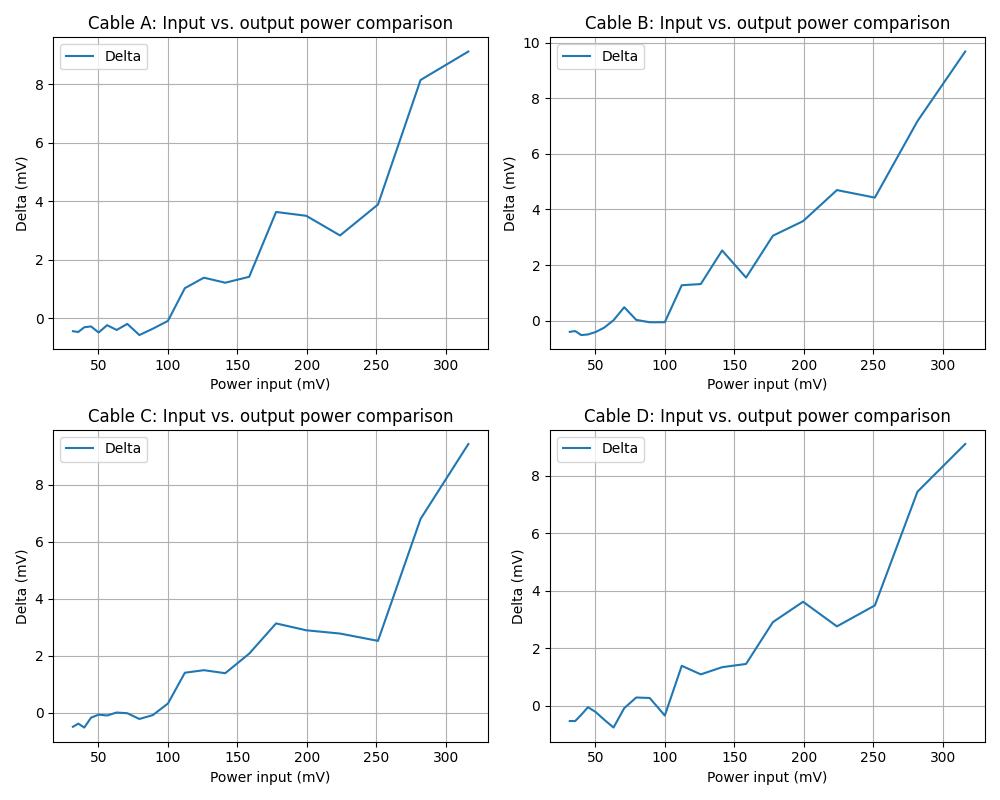

In [9]:
if flag_load_data:
	cables = ['C_A', 'C_B', 'C_C', 'C_D']
	
	dict = {}
	deltas_matrix = []
	input_matrix = []
	
	for C in cables:
		data = load_hdf5_to_dict('cables.h5')[C]
		powers = data['powers']
		dict[C] = {'freq_(Hz)': data['freq_(Hz)']}
		digits_p = "{:0"+str(len(str(len(powers))))+"d}"
		
		deltas_row = []
		input_row = []
		
		for i, p in enumerate(powers.values()):
			y = p['sweep']
			x, idx = data_amps(y, False)
			avg_amplitude = np.mean(y[idx]) * 1e3
			input_power = T.dBm_to_mVpk(p['power_(dBm)'])
			delta = input_power - avg_amplitude
			dict[C][f'p{digits_p.format(i)}'] = {'input_power': input_power, 
												 'output_power': avg_amplitude,
												 'delta': delta}
			deltas_row.append(delta)
			input_row.append(input_power)
		
		deltas_matrix.append(deltas_row)
		input_matrix.append(input_row)
	
	deltas_matrix = np.array(deltas_matrix)
	input_matrix = np.array(input_matrix)
	save_dict_to_hdf5(dict, 'IN-OUT_amp.h5')
	
	# Crea una griglia 2x2 di subplot
	fig, axs = plt.subplots(2, 2, figsize=(10, 8))

	# Lista dei titoli dei subplot
	titles = ['Cable A', 'Cable B', 'Cable C', 'Cable D']

	for i in range(4):
		x_data = input_matrix[i]
		y_data = deltas_matrix[i]
		axs[i // 2, i % 2].plot(x_data, y_data, label='Delta')
		axs[i // 2, i % 2].set_xlabel('Power input (mV)')
		axs[i // 2, i % 2].set_ylabel('Delta (mV)')
		
		axs[i // 2, i % 2].set_title(titles[i]+': Input vs. output power comparison')
		axs[i // 2, i % 2].grid(True)
		axs[i // 2, i % 2].legend()

	plt.tight_layout() 
	plt.show()


In [12]:
print('dBm', T.mVpp_to_dBm(8))
print('dBm', T.mVpk_to_dBm(100))
print('dBm', T.mVrms_to_dBm(8))

print('Vpk', T.dBm_to_mVpk(-6))
print('Vpp', T.dBm_to_mVpp(-6))
print('Vrms', T.dBm_to_mVrms(-6))

dBm -37.95880017344075
dBm -9.999999999999998
dBm -28.927900303521316
Vpk 158.4893192461113
Vpp 316.9786384922226
Vrms 112.06887238456493
